## Horizontal Photovoltaic Power Prediction for 12 Sites

### Import relevant libraries

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn .svm import SVR

from lightgbm import LGBMRegressor

### Load dataset

In [ ]:
df = pd.read_csv('Pasion et al dataset.csv')

### Explore the data

##### Identify available columns in the data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       21045 non-null  object 
 1   Date           21045 non-null  int64  
 2   Time           21045 non-null  int64  
 3   Latitude       21045 non-null  float64
 4   Longitude      21045 non-null  float64
 5   Altitude       21045 non-null  int64  
 6   YRMODAHRMI     21045 non-null  float64
 7   Month          21045 non-null  int64  
 8   Hour           21045 non-null  int64  
 9   Season         21045 non-null  object 
 10  Humidity       21045 non-null  float64
 11  AmbientTemp    21045 non-null  float64
 12  PolyPwr        21045 non-null  float64
 13  Wind.Speed     21045 non-null  int64  
 14  Visibility     21045 non-null  float64
 15  Pressure       21045 non-null  float64
 16  Cloud.Ceiling  21045 non-null  int64  
dtypes: float64(8), int64(7), object(2)
memory usage: 2

In [ ]:
df.drop('YRMODAHRMI', axis=1, inplace=True)

In [ ]:
df.head()

,Location,Date,Time,Latitude,Longitude,Altitude,Month,Hour,Season,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
0,Camp Murray,20171203,1145,47.11,-122.57,84,12,11,Winter,81.71997,12.86919,2.42769,5,10.0,1010.6,722
1,Camp Murray,20171203,1315,47.11,-122.57,84,12,13,Winter,96.64917,9.66415,2.46273,0,10.0,1011.3,23
2,Camp Murray,20171203,1330,47.11,-122.57,84,12,13,Winter,93.61572,15.44983,4.46836,5,10.0,1011.6,32
3,Camp Murray,20171204,1230,47.11,-122.57,84,12,12,Winter,77.21558,10.36659,1.65364,5,2.0,1024.4,6
4,Camp Murray,20171204,1415,47.11,-122.57,84,12,14,Winter,54.80347,16.85471,6.57939,3,3.0,1023.7,9


##### Calculate summary statistics of numerical columns

In [ ]:
df.describe()

,Date,Time,Latitude,Longitude,Altitude,Month,Hour,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
count,2.104500e+04,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000
mean,2.017720e+07,1267.483725,38.213823,-108.593678,798.843668,6.565883,12.627845,37.121941,29.285117,12.978583,10.318318,9.700071,925.944747,515.966785
std,4.579585e+03,167.602767,6.323761,16.364130,770.681794,2.983958,1.672952,23.823011,12.366820,7.123255,6.385030,1.351949,85.215659,301.903379
min,2.017052e+07,1000.000000,20.890000,-156.440000,1.000000,1.000000,10.000000,0.000000,-19.981770,0.257330,0.000000,0.000000,781.700000,0.000000
25%,2.017111e+07,1100.000000,38.160000,-117.260000,2.000000,4.000000,11.000000,17.529300,21.915280,6.404570,6.000000,10.000000,845.500000,140.000000
50%,2.018032e+07,1300.000000,38.950000,-111.180000,458.000000,7.000000,13.000000,33.123780,30.289150,13.798700,9.000000,10.000000,961.100000,722.000000
75%,2.018062e+07,1400.000000,41.150000,-104.710000,1370.000000,9.000000,14.000000,52.593990,37.474670,18.863650,14.000000,10.000000,1008.900000,722.000000
max,2.018100e+07,1545.000000,47.520000,-80.110000,1947.000000,12.000000,15.000000,99.987790,65.738370,34.285020,49.000000,10.000000,1029.500000,722.000000


##### Visualize data distribution

In [ ]:
# sns.pairplot(df)

##### Correlation analysis

In [ ]:
df_corr = df[['Location', 'Latitude', 'Longitude', 'Altitude',
              'Month', 'Hour', 'Season', 'Humidity', 'AmbientTemp',
              'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling', 'PolyPwr']].corr()

<ipython-input-24-34fbcae2b1fe>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling', 'PolyPwr']].corr()


In [ ]:
mask = np.triu(np.ones_like(df_corr, dtype=bool))

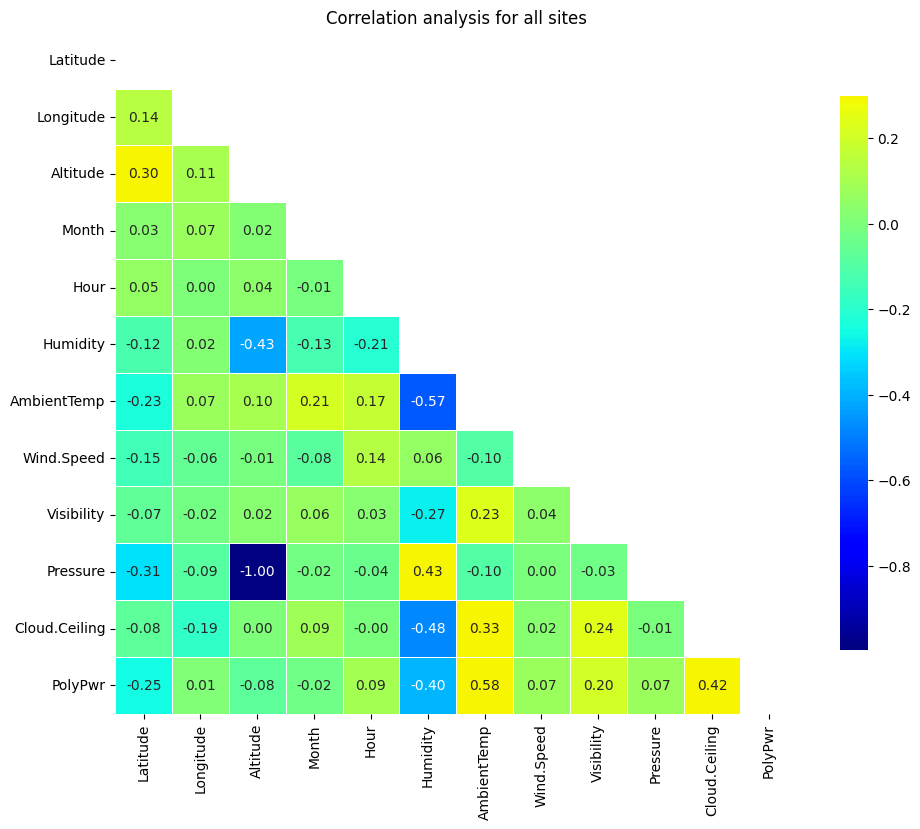

In [ ]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_corr, mask=mask, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8});
plt.title('Correlation analysis for all sites');

### Summary of data Explorartion

<font size="3"> 1. The correlation between Ambient temperature, humidity and power improved when using site level data rather than fleet level data.<br/>
<font size="3"> 2. Also, some input features have their correlation sign with target change for individual sites compared with total sites data (e.g windspeed). <br/>
<font size="3"> 3. Hence, it may be necessary to build machine learning models per site to get the best out of the models. It might also be worth trying to encode the site-specific features like site location.<br/>
<font size="3"> 4. Altitude and pressure are perfectly correlated however, altitude does not change for a particular site and cannot be used for site-level modeling.

### Data Preprocessing

##### Check for missing values

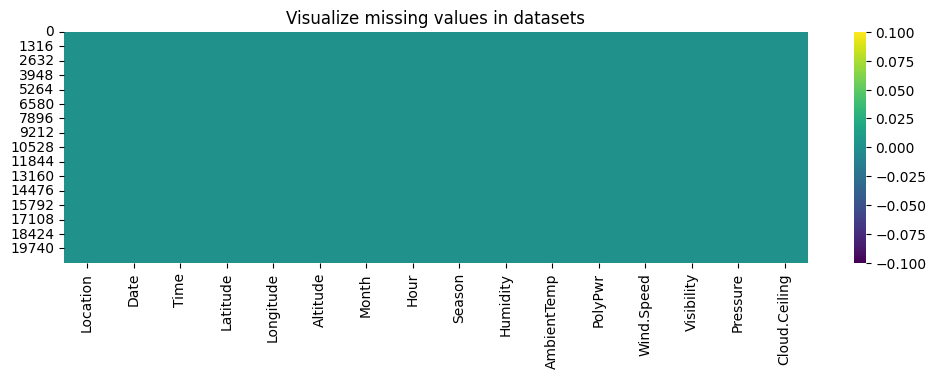

In [ ]:
plt.figure(figsize=(12, 3))
sns.heatmap(df.isnull(), cmap='viridis');
plt.title('Visualize missing values in datasets');

##### Feature Engineering

In [ ]:
# Encode location data
df_with_location_en = pd.get_dummies(df, columns=['Location'], drop_first=True)

In [ ]:
# Encode season data
df_with_loc_season_en = pd.get_dummies(df_with_location_en, columns=['Season'], drop_first=True)

In [ ]:
min_hour_of_interest = 10
max_hour_of_interest = 15

In [ ]:
df_with_loc_season_en['delta_hr']= df_with_loc_season_en.Hour - min_hour_of_interest

In [ ]:
# Create Cyclic date features
df_with_loc_season_en['sine_mon']= np.sin((df_with_loc_season_en.Month - 1)*np.pi/11)
df_with_loc_season_en['cos_mon']= np.cos((df_with_loc_season_en.Month - 1)*np.pi/11)
df_with_loc_season_en['sine_hr']= np.sin((df_with_loc_season_en.delta_hr*np.pi/(max_hour_of_interest - min_hour_of_interest)))
df_with_loc_season_en['cos_hr']= np.cos((df_with_loc_season_en.delta_hr*np.pi/(max_hour_of_interest - min_hour_of_interest)))

In [ ]:
mask2 = np.triu(np.ones_like(df_with_loc_season_en.corr(), dtype=bool))

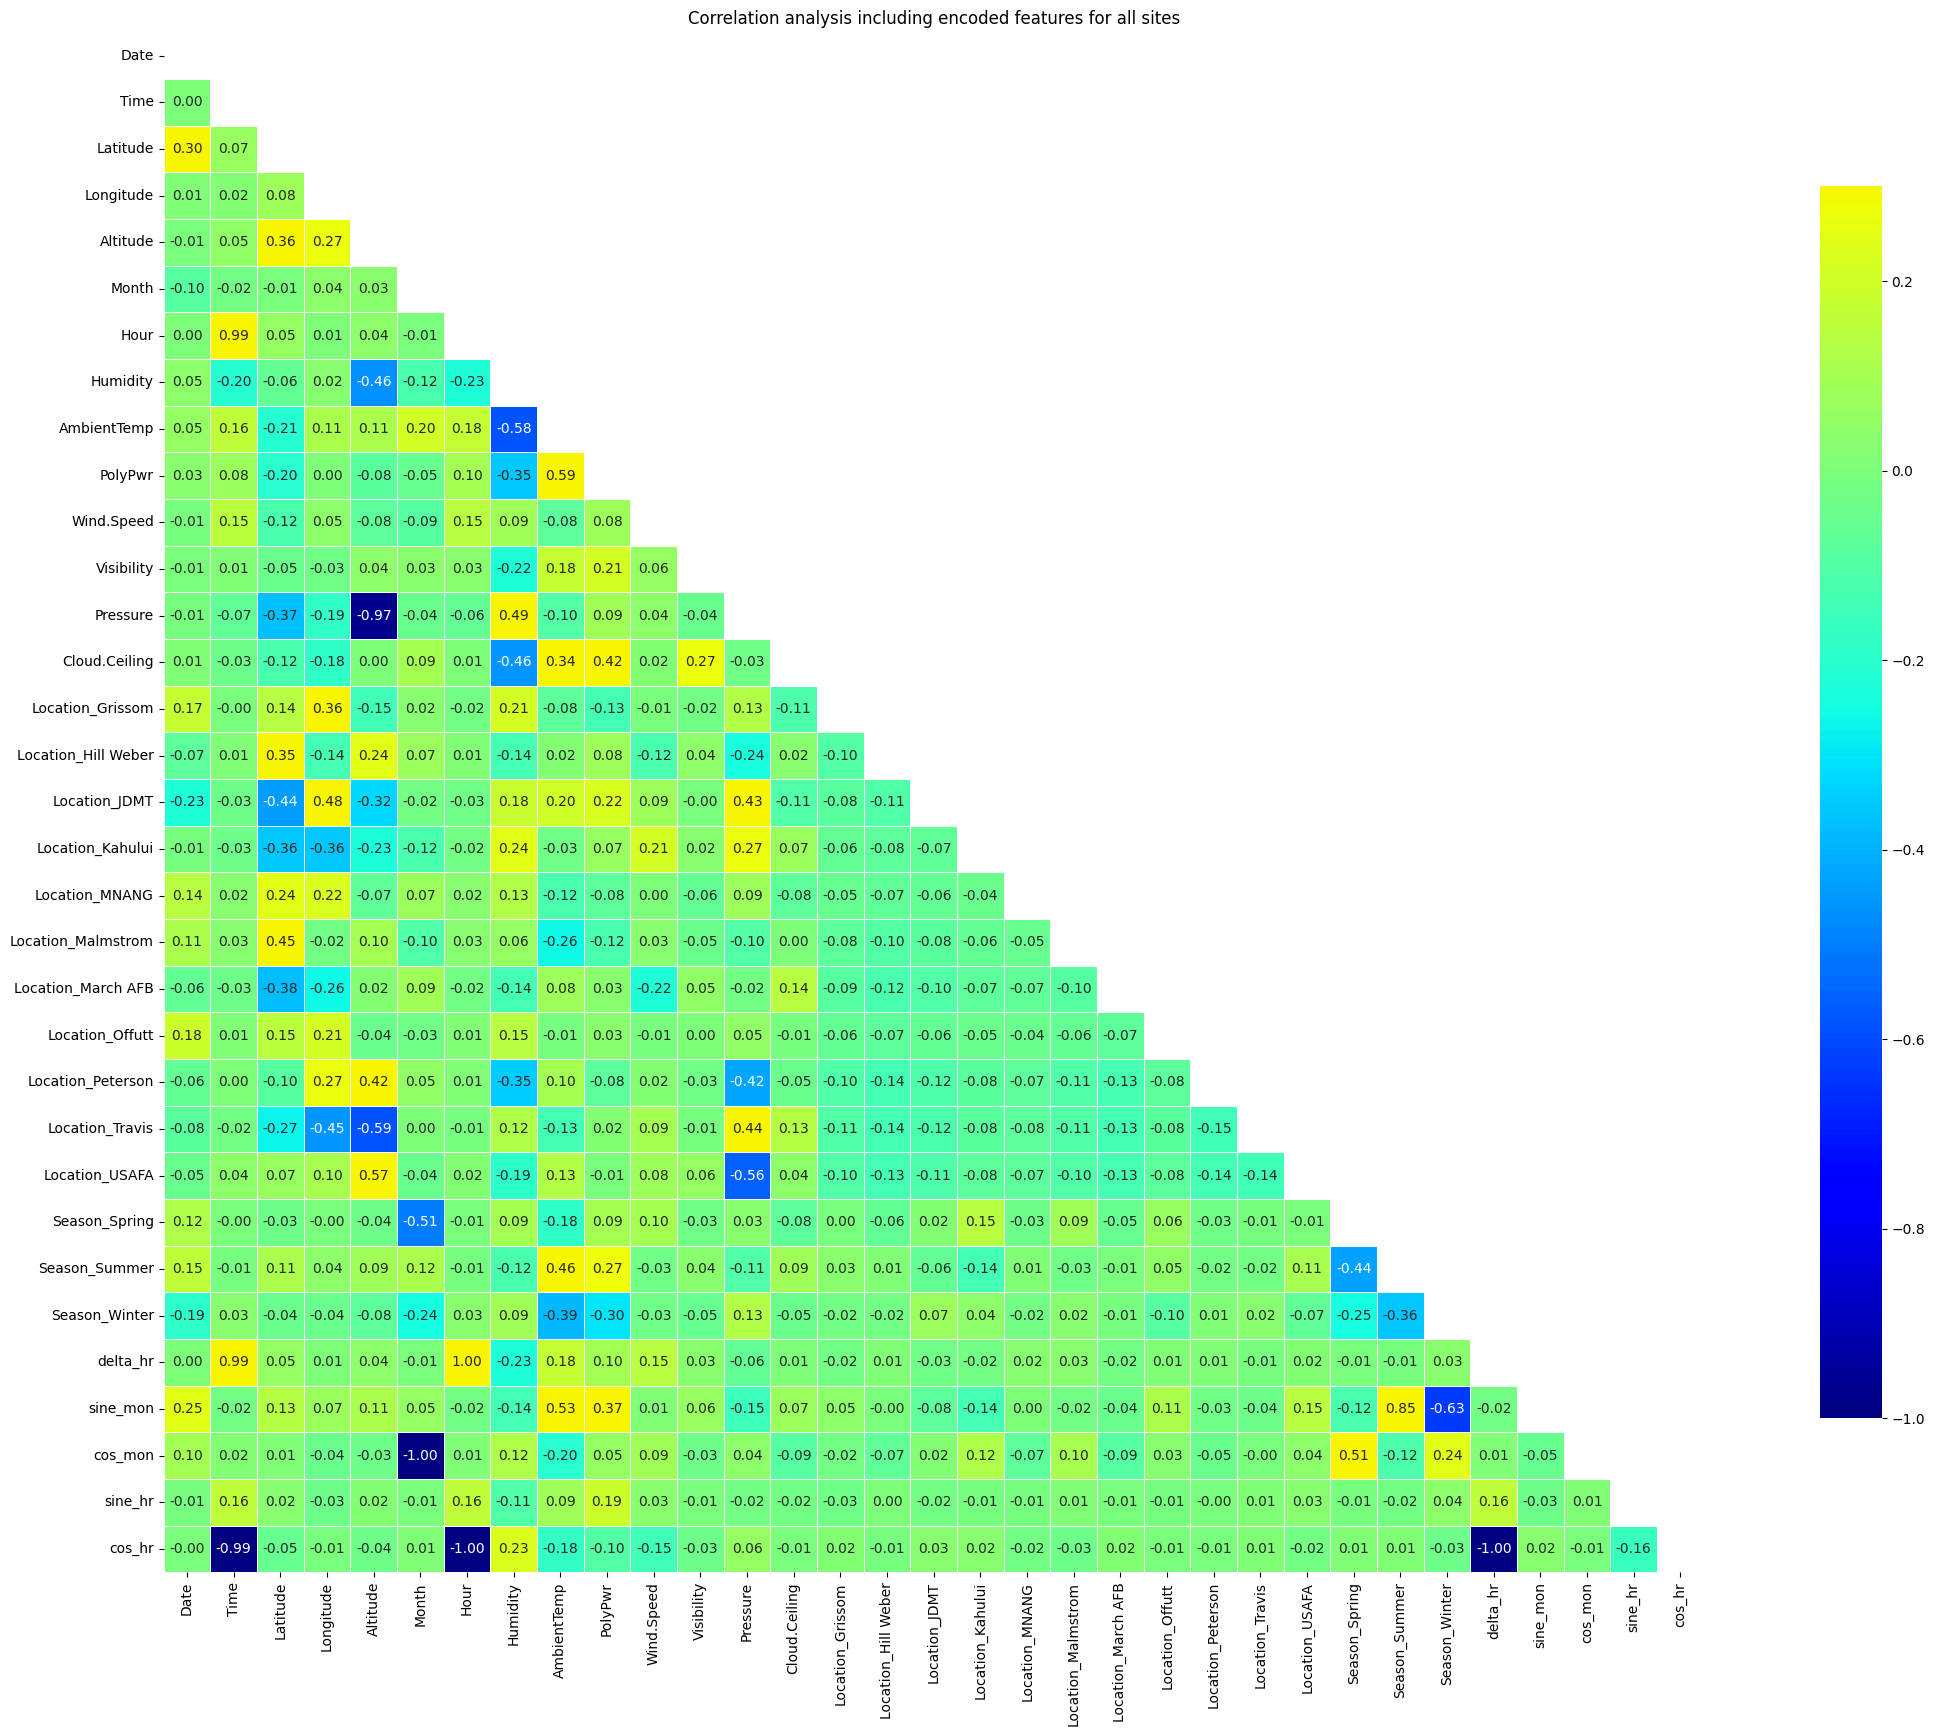

In [ ]:
f, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(df_with_loc_season_en.corr(method='spearman'), mask=mask2, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8});
plt.title('Correlation analysis including encoded features for all sites');

### Modeling

##### Feature Selection

In [ ]:
selected_columns = ['Latitude', 'Humidity', 'AmbientTemp', 'PolyPwr', 'Wind.Speed',
                     'Visibility', 'Pressure', 'Cloud.Ceiling', 'Location_Grissom',
                     'Location_Hill Weber', 'Location_JDMT', 'Location_Kahului',
                     'Location_MNANG', 'Location_Malmstrom', 'Location_March AFB',
                     'Location_Offutt', 'Location_Peterson', 'Location_Travis',
                     'Location_USAFA','Season_Spring', 'Season_Summer', 'Season_Winter',
                     'sine_mon', 'cos_mon',  'sine_hr', 'cos_hr']

In [ ]:
df_processed = df_with_loc_season_en[selected_columns].reset_index(drop=True)

In [ ]:
target_label = 'PolyPwr'

In [ ]:
input_feat = list(set(selected_columns).difference(set([target_label])))

##### Summary of feature selection

<font size="3"> 1. Altitude is dropped because it has a high correlation with Pressure but does not change for a given location while presesure is more dynamic. <br/>
<font size="3"> 2. Longitude is dropped because it has zero correlation with the target variable. <br/>
<font size="3"> 3. Time, Hour, Month and Date are dropped because they have strong correlations with the engineered cyclic features but low correlation with the target variable. 

##### Extract test set from all data

In [ ]:
df_X = df_processed[input_feat].reset_index(drop=True)

In [ ]:
df_y = df_processed[target_label]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

### Build base models with optimal hyper-params

##### Neural Network model set up

In [ ]:
os.environ['PYTHONHASHSEED'] = str(33)
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dense, Conv1D, ReLU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K

In [ ]:
tf.random.set_seed(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
def dl_model(n_units1, n_units2, n_units3, act1, act2, act3, ker_init, lr, dr0, dr1, dl_loss):
    model = Sequential()
    model.add(Dense(n_units1, activation=act1, kernel_initializer=ker_init, input_dim=X_train.shape[1]))
    model.add(Dropout(dr0))
    model.add(Dense(n_units2, activation=act2, kernel_initializer=ker_init))
    model.add(Dropout(dr1))
    model.add(Dense(n_units3, activation=act3, kernel_initializer=ker_init))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=[r_squared, tf.keras.metrics.mean_squared_error], loss=dl_loss)
    return model

In [ ]:
def custom_loss(y_true, y_pred):
    # (1-R2)
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true-K.mean(y_true)))
    return SS_res/(SS_tot+K.epsilon())

In [ ]:
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true-K.mean(y_true)))
    return (1-SS_res/(SS_tot+K.epsilon()))

##### Build NN training pipeline

In [ ]:
# Scale training data
estimators = []
estimators.append(('standardize', StandardScaler()))
kr_regressor = KerasRegressor(build_fn=dl_model)
kr_regressor._estimator_type = "regressor"
estimators.append(('kr', kr_regressor))
pipeline = Pipeline(estimators)

<ipython-input-47-286089f52036>:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  kr_regressor = KerasRegressor(build_fn=dl_model)


##### Train NN model using optimal hyper-parameters from above

In [ ]:
dl_best_params = {'kr__n_units3':320, 'kr__n_units2':240, 'kr__n_units1':280, 'kr__lr':0.001,
                  'kr__ker_init':tf.keras.initializers.GlorotUniform(seed=32), 'kr__epochs':70, 'kr__dr1':0.1, 'kr__dr0':0.1,
                  'kr__dl_loss':custom_loss,
                  'kr__batch_size':600, 'kr__act3':'tanh', 'kr__act2':'relu', 'kr__act1':'relu', 'kr__verbose':0}

In [ ]:
dl_model = pipeline.set_params(**dl_best_params)

##### Build LGBM model

In [ ]:
lgbm_best_params = {'objective':'rmse', 'num_leaves':1400, 'n_estimators':900, 'max_depth':11, 'learning_rate':0.008,
                    'feature_fraction':0.6, 'random_state':42}

In [ ]:
lgbm_model = LGBMRegressor(**lgbm_best_params)

##### Build RandomForest model

In [ ]:
rf_best_params = {'max_features':'sqrt', 'min_samples_split':5, 'min_samples_leaf':2, 'n_estimators':1800, 'max_depth':20, 'bootstrap':True, 'random_state':42}

In [ ]:
rf_model = RandomForestRegressor(**rf_best_params)

##### Build KNN model

In [ ]:
# Scale training data
knn_estimators = []
knn_estimators.append(('knn_standardize', StandardScaler()))
# estimators.append(('minmax', MinMaxScaler()))
knn_estimators.append(('knn', KNeighborsRegressor()))
knn_pipeline = Pipeline(knn_estimators)

In [ ]:
knn_best_params = {'knn__weights': 'distance', 'knn__p': 2, 'knn__n_neighbors': 15, 'knn__leaf_size': 30, 'knn__algorithm': 'ball_tree'}

In [ ]:
knn_model = knn_pipeline.set_params(**knn_best_params)

##### Build Meta learner model

In [ ]:
# Define the base models
base0 = list()
base0.append(('dl', dl_model))
base0.append(('lgbm', lgbm_model))
base0.append(('rf', rf_model))
base0.append(('knn', knn_model))

In [ ]:
# Define meta learner model
base1 = LinearRegression()

In [ ]:
# Define the stacking ensemble
stacked_model = StackingRegressor(estimators=base0, final_estimator=base1, cv=4, passthrough=True)

In [ ]:
%%time
# Fit the model on the training data
stacked_model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
CPU times: user 5min 54s, sys: 5.28 s, total: 6min
Wall time: 5min 58s


StackingRegressor(cv=4,
                  estimators=[('dl',
                               Pipeline(steps=[('standardize',
                                                StandardScaler()),
                                               ('kr',
                                                <keras.wrappers.scikit_learn.KerasRegressor object at 0x7f8fb6123dc0>)])),
                              ('lgbm',
                               LGBMRegressor(feature_fraction=0.6,
                                             learning_rate=0.008, max_depth=11,
                                             n_estimators=900, num_leaves=1400,
                                             objective='rmse',
                                             random_state=42)),
                              ('rf',
                               RandomForestRegressor(max_depth=20,
                                                     max_features='sqrt',
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=1800,
                                                     random_state=42)),
                              ('knn',
                               Pipeline(steps=[('knn_standardize',
                                                StandardScaler()),
                                               ('knn',
                                                KNeighborsRegressor(algorithm='ball_tree',
                                                                    n_neighbors=15,
                                                                    weights='distance'))]))],
                  final_estimator=LinearRegression(), passthrough=True)

##### Make model inferences on test set

In [ ]:
y_pred = stacked_model.predict(X_test)

##### Evaluate model performance on test set

In [ ]:
# Explained variance
explained_variance_score(y_test.ravel(), y_pred)

0.6806897974904792

In [ ]:
# R2 score
r2_score(y_test.ravel(), y_pred)

0.6806577013420516

In [ ]:
# Mean absolute error
mean_absolute_error(y_test.ravel(), y_pred)

2.675262103935539

In [ ]:
# Root mean square error
np.sqrt(mean_squared_error(y_test.ravel(), y_pred))

4.027747614813326

In [ ]:
mean_absolute_percentage_error(y_test.ravel(), y_pred)*100

49.59742212824616

In [ ]:
# Let's try building model for every location
unique_locations = df['Location'].unique()

unique_locations

array(['Camp Murray', 'Grissom', 'Hill Weber', 'JDMT', 'Kahului',
       'Malmstrom', 'March AFB', 'MNANG', 'Offutt', 'Peterson', 'Travis',
       'USAFA'], dtype=object)

In [ ]:
for location in unique_locations:
    location_df = df[df['Location'] == location]
    location_filename = f'{location}_dataset.csv'
    location_df.to_csv(location_filename, index=False)
    print(f"Dataset for {location} saved as {location_filename}.")


Dataset for Camp Murray saved as Camp Murray_dataset.csv.
Dataset for Grissom saved as Grissom_dataset.csv.
Dataset for Hill Weber saved as Hill Weber_dataset.csv.
Dataset for JDMT saved as JDMT_dataset.csv.
Dataset for Kahului saved as Kahului_dataset.csv.
Dataset for Malmstrom saved as Malmstrom_dataset.csv.
Dataset for March AFB saved as March AFB_dataset.csv.
Dataset for MNANG saved as MNANG_dataset.csv.
Dataset for Offutt saved as Offutt_dataset.csv.
Dataset for Peterson saved as Peterson_dataset.csv.
Dataset for Travis saved as Travis_dataset.csv.
Dataset for USAFA saved as USAFA_dataset.csv.


In [ ]:
for location in unique_locations:
    print("LOCATION IS: ", location)
    location_df = pd.read_csv(f'{location}_dataset.csv')
    location_df = location_df.drop('Location', axis=1)
    df_with_loc_season_en = pd.get_dummies(location_df, columns=['Season'], drop_first=True)

    unique_seasons = location_df['Season'].unique()
    seasons_for_list = [f"Season_{x}" for x in sorted(unique_seasons)[1:]]
    print("Available Seasons:", seasons_for_list)

    df_with_loc_season_en['delta_hr']= df_with_loc_season_en.Hour - min_hour_of_interest
    df_with_loc_season_en['sine_mon']= np.sin((df_with_loc_season_en.Month - 1)*np.pi/11)
    df_with_loc_season_en['cos_mon']= np.cos((df_with_loc_season_en.Month - 1)*np.pi/11)
    df_with_loc_season_en['sine_hr']= np.sin((df_with_loc_season_en.delta_hr*np.pi/(max_hour_of_interest - min_hour_of_interest)))
    df_with_loc_season_en['cos_hr']= np.cos((df_with_loc_season_en.delta_hr*np.pi/(max_hour_of_interest - min_hour_of_interest)))

    selected_columns = ['Latitude', 'Humidity', 'AmbientTemp', 'PolyPwr', 'Wind.Speed',
                     'Visibility', 'Pressure', 'Cloud.Ceiling',
                     'sine_mon', 'cos_mon',  'sine_hr', 'cos_hr', *seasons_for_list]
                  
    df_processed = df_with_loc_season_en[selected_columns].reset_index(drop=True)
    target_label = 'PolyPwr'
    input_feat = list(set(selected_columns).difference(set([target_label])))

    df_X = df_processed[input_feat].reset_index(drop=True)
    df_y = df_processed[target_label]
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

    # Scale training data
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    # kr_regressor = KerasRegressor(build_fn=dl_model)
    kr_regressor._estimator_type = "regressor"
    estimators.append(('kr', kr_regressor))
    pipeline = Pipeline(estimators)

    # %%time
    # Fit the model on the training data
    stacked_model.fit(X_train, y_train)
    y_pred = stacked_model.predict(X_test)

    # Explained variance
    print("Explained Variance Score:", explained_variance_score(y_test.ravel(), y_pred))

    # R2 score
    print("R^2 score", r2_score(y_test.ravel(), y_pred))

    # Mean absolute error
    print("Mean absolute error", mean_absolute_error(y_test.ravel(), y_pred))

    print("The same one, but in percents:", mean_absolute_percentage_error(y_test.ravel(), y_pred)*100)

LOCATION IS:  Camp Murray
Available Seasons: ['Season_Spring', 'Season_Summer', 'Season_Winter']
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Explained Variance Score: 0.7546634642444886
R^2 score 0.7520017214968803
Mean absolute error 2.3575552345803894
The same one, but in percents: 40.94700287800453
LOCATION IS:  Grissom
Available Seasons: ['Season_Spring', 'Season_Summer', 'Season_Winter']
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature